In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
import time
start = time.time()

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 7, 6

from copy import deepcopy
import seaborn as sns

# import sys
# sys.path.append('utils')
# from utils import review_feature
# rf = review_feature()
# %matplotlib inline

In [ ]:
from zipfile import ZipFile
import urllib.request
from io import BytesIO
folder = urllib.request.urlopen('https://s3.amazonaws.com/projex.dezyre.com/ecommerce-product-reviews-ranking-sentiment-analysis/materials/data.zip')
zipfile = ZipFile(BytesIO(folder.read()))
zipfile.namelist()

['Features.csv',
 'Preprocessed_Reviews.csv',
 'test.csv',
 'test_ranked_output.csv',
 'test_withoutlabel.csv',
 'train.csv',
 'train_ranked_output.csv']

In [ ]:
df = pd.read_csv(zipfile.open('train.csv'))

In [ ]:
df

,product,answer_option,label
0,Accucheck,Fast and accurate delivery,0
1,Accucheck,As usual it is genuine,0
2,Accucheck,Behavior of delivery boy is very bad. Delivery...,0
3,Accucheck,fwegwrqdsdvwfg,0
4,Accucheck,These strips were as per my requirment,0
...,...,...,...
1671,Accucheck,Ft GM,0
1672,Accucheck,I like,0
1673,Accucheck,Nice price with long expiry,0
1674,Accucheck,Price & Service,0


## Analysis to understand per product who many informative and how many not informative reviews are there. 

In [ ]:
label_analysis = pd.crosstab(df['product'],df['label'], margins='All')
label_analysis

label,0,1,All
product,,,
Accucheck,317,85,402
Becadexamin,53,27,80
Evion,89,33,122
Neurobion,286,137,423
SevenseascodLiverOil,60,22,82
Shelcal,262,126,388
Supradyn,50,23,73
shampoo,57,49,106
All,1174,502,1676


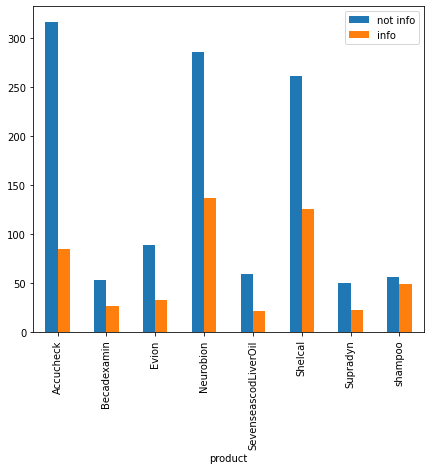

In [ ]:
analysis = label_analysis.reset_index()
analysis.columns = ['product','not info', 'info', 'All']
analysis.iloc[:-1].plot(x="product", y=["not info", "info"], kind="bar")

## Lets check the length quality of reviews we have?

In [ ]:
df['review_len'] = df['answer_option'].apply(lambda x: len(x.split()))

In [ ]:
df

,product,answer_option,label,review_len
0,Accucheck,Fast and accurate delivery,0,4
1,Accucheck,As usual it is genuine,0,5
2,Accucheck,Behavior of delivery boy is very bad. Delivery...,0,20
3,Accucheck,fwegwrqdsdvwfg,0,1
4,Accucheck,These strips were as per my requirment,0,7
...,...,...,...,...
1671,Accucheck,Ft GM,0,2
1672,Accucheck,I like,0,2
1673,Accucheck,Nice price with long expiry,0,5
1674,Accucheck,Price & Service,0,3


In [ ]:
checklen = []
for i in range(5,50, 5):
    checklen.append(len(df[ (df['review_len']>=i-5) & (df['review_len']<i)]))

In [ ]:
checklen

[780, 603, 149, 65, 29, 22, 9, 6, 3]

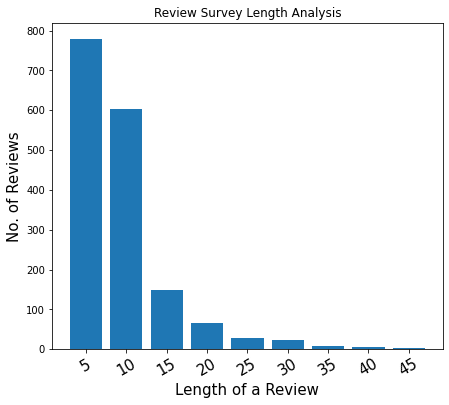

In [ ]:
index = np.arange(len(checklen))
plt.bar(index, checklen)
plt.xlabel('Length of a Review', fontsize=15)
plt.ylabel('No. of Reviews', fontsize=15)
plt.xticks(index, range(5,50,5), fontsize=15, rotation=30)
plt.title('Review Survey Length Analysis')
plt.show()

## We have a fair amount of both details reviews (having length >=5) and short reviews (having length <5)

## Data Preprocessing

![datapreprocessing](Photos/datapreprocessing.png)

## Stage1: Language Detection

In [ ]:
pip install jellyfish

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 132 kB 25.7 MB/s 
  Created wheel for jellyfish: filename=jellyfish-0.9.0-cp38-cp38-linux_x86_64.whl size=70642 sha256=53e9ced50feb8301e92f8479bc9f37f4a0c49bbf44adea3b43f3a09ec9e96010
  Stored in directory: /root/.cache/pip/wheels/f1/c7/3c/4c83132de76359e3a429fd09c08995945ca96c5290a41651d3
Successfully built jellyfish


In [ ]:
pip install langdetect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 981 kB 27.0 MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=f68bb46537858dfb95a2f3a4827d9bc86bef8906c87e21e97d2532f592752dd3
  Stored in directory: /root/.cache/pip/wheels/13/c7/b0/79f66658626032e78fc1a83103690ef6797d551cb22e56e734
Successfully built langdetect


In [ ]:
pip install vaderSentiment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 35.2 MB/s 


In [ ]:
# class review_feature:
#     def __init__(self):
#         self.analyzer = SentimentIntensityAnalyzer()
#         self.hindi_swear_words = None
#         self.english_swear_words = None
#         self.tagger = None
#         self.company_tag = None
#         self.model_data = None
#         pass
#     def subjectivity_sentiment(self,text):
#         '''
#         input: string
#         output: 0 to 1
#         '''
#         blob = TextBlob(text)
#         return (blob.sentiment.subjectivity)
#     def slang_emoji_polarity_compoundscore(self,text):
#         '''
#         Input: Text
#         Output:
#         (-0.5 to +0.5): Neural
#         (-inf to -0.5): Negative
#         (+0.5 to +inf): Positive
#         '''
#         return self.analyzer.polarity_scores(text)['compound']

#     def gibberish_detection(self,l, prefix_path = './'):
#         '''
#         Input: String
#         prefix_path: path of gibberish pickle weights
#         Output: True or False
#         '''
#         if self.model_data == None:
#             self.model_data = pickle.load(open('/content/drive/MyDrive/Datasets/sentiment_analysis/utils/DictionaryUtils/gib_model.pki', 'rb'))

#         accepted_chars = 'abcdefghijklmnopqrstuvwxyz '
#         pos = dict([(char, idx) for idx, char in enumerate(accepted_chars)])
    



   

In [ ]:
from nltk.metrics import edit_distance
from textblob import TextBlob, Word
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import urllib.request
import pickle
import jellyfish
import math
from langdetect import detect
import os
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import PorterStemmer
import pandas as pd

nlp = spacy.load("en_core_web_sm")
stemmer = PorterStemmer()

class review_feature:
    def __init__(self):
        self.analyzer = SentimentIntensityAnalyzer()
        self.hindi_swear_words = None
        self.english_swear_words = None
        self.tagger = None
        self.company_tag = None
        self.model_data = None
        pass

    def hindi_swear_check(self,string, print_word = False):
        '''
        input: string
        output: True if text has hinglish proganity False if no profanity
        '''
        if self.hindi_swear_words == None:
            self.hindi_swear_words = []
            try:
                with open('/content/drive/MyDrive/Datasets/sentiment_analysis/utils/DictionaryUtils/hindi_swear_words.txt','r') as fp:
                    data = fp.read().lower()
                result = data.split('\n')
                self.hindi_swear_words = set([x.split('~')[0][:-1].lower() for x in result])
            except:
                print('Warning: hindi_swear_words.txt not read')
                pass
            self.hindi_swear_words = set(self.hindi_swear_words)
            if '' in self.hindi_swear_words or ' ' in self.hindi_swear_words:
                self.hindi_swear_words.pop()

        for word in self.hindi_swear_words:
            if word in string.lower().split():
                if print_word == True:
                    print(word)
                return True
        return False

    def english_swear_check(self,string, print_word = False):
        '''
        input: string
        output: True if text has english proganity False if no profanity
        '''
        if self.english_swear_words == None:
            self.english_swear_words = []
            try:
                with open('/content/drive/MyDrive/Datasets/sentiment_analysis/utils/DictionaryUtils/english_profanity_google.txt','r') as fp:
                    data = fp.read().lower()
                self.english_swear_words = set(data.split('\n'))
            except:
                print('Warning: english_profanity_google.txt not read')
                pass
            self.english_swear_words = set(self.english_swear_words)
            if '' in self.english_swear_words or ' ' in self.english_swear_words:
                self.english_swear_words.pop()

        for word in self.english_swear_words:
            if word in string.lower().split():
                if print_word == True:
                    print(word)
                return True
        return False

    def spell_correct(self,text,spell_threshold):
        '''
        text: string input
        spell_threshold: how much correction is required | keeping value higher is better
        '''
        text_list = text.split()
        ouput = " "
        for i in range(len(text_list)):
            w = Word(text_list[i])
            if w.spellcheck()[0][1]>spell_threshold:
                text_list[i] = w.spellcheck()[0][0]
        return ouput.join(text_list)

    def service_tag(self,text, print_word = False):
        '''
        text: string input
        output: 0 or 1
        '''
        if self.tagger == None:
            self.tagger = []
            try:
                with open('/content/drive/MyDrive/Datasets/sentiment_analysis/utils/DictionaryUtils/service_tagger.txt','r') as fp:
                    data = fp.read().lower()
                self.tagger = set(data.split('\n'))
            except:
                print('Warning: Service_tagger.txt not read')
                pass
            self.tagger = set(self.tagger)

            if '' in self.tagger or ' ' in self.tagger:
                self.tagger.pop()

        k = text.split()
        for w in k:
            for wrd in self.tagger:
                x = edit_distance(w.lower(),wrd)
                if x<=1:
                    if print_word == True:
                        print(wrd)
                    return 1
        return 0

    def polarity_sentiment(self,text):
        '''
        input: string
        output: value between -1 to +1
        '''
        blob = TextBlob(text)
        return (blob.sentiment.polarity)

    def subjectivity_sentiment(self,text):
        '''
        input: string
        output: 0 to 1
        '''
        blob = TextBlob(text)
        return (blob.sentiment.subjectivity)

    def slang_emoji_polarity_compoundscore(self,text):
        '''
        Input: Text
        Output:
        (-0.5 to +0.5): Neural
        (-inf to -0.5): Negative
        (+0.5 to +inf): Positive
        '''
        return self.analyzer.polarity_scores(text)['compound']

    def string_comparison(self,text1,text2,choice='levenshtein_distance'):
        '''
        text1: String Input 1
        text2: String Input 2
        choice: 'levenshtein_distance' or 'damerau_levenshtein_distance' or 'hamming_distance' or 'jaro_distance' or 'jaro_winkler' or 'match_rating_comparison'
        '''
        # https://jellyfish.readthedocs.io/en/latest/comparison.html
        if choice == 'levenshtein_distance':
            return jellyfish.levenshtein_distance(text1,text2)
        elif choice == 'damerau_levenshtein_distance':
            return jellyfish.damerau_levenshtein_distance(text1,text2)
        elif choice == 'hamming_distance':
            return jellyfish.hamming_distance(text1,text2)
        elif choice == 'jaro_distance':
            return jellyfish.jaro_distance(text1,text2)
        elif choice == 'jaro_winkler':
            return jellyfish.jaro_winkler(text1,text2)
        elif choice == 'match_rating_comparison':
            return jellyfish.match_rating_comparison(text1,text2)
        else:
            print("Wrong Choice")

    def gibberish_detection(self,l, prefix_path = './'):
        '''
        Input: String
        prefix_path: path of gibberish pickle weights
        Output: True or False
        '''
        if self.model_data == None:
            self.model_data = pickle.load(open('/content/drive/MyDrive/Datasets/sentiment_analysis/utils/DictionaryUtils/gib_model.pki', 'rb'))

        accepted_chars = 'abcdefghijklmnopqrstuvwxyz '
        pos = dict([(char, idx) for idx, char in enumerate(accepted_chars)])

        def normalize(line):
            """ Return only the subset of chars from accepted_chars.
            This helps keep the  model relatively small by ignoring punctuation,
            infrequenty symbols, etc. """
            return [c.lower() for c in line if c.lower() in accepted_chars]

        def ngram(n, l):
            """ Return all n grams from l after normalizing """
            filtered = normalize(l)
            for start in range(0, len(filtered) - n + 1):
                yield ''.join(filtered[start:start + n])

        def avg_transition_prob(l, log_prob_mat):
            """ Return the average transition prob from l through log_prob_mat. """
            log_prob = 0.0
            transition_ct = 0
            for a, b in ngram(2, l):
                log_prob += log_prob_mat[pos[a]][pos[b]]
                transition_ct += 1
            # The exponentiation translates from log probs to probs.
            return math.exp(log_prob / (transition_ct or 1))

        model_mat = self.model_data['mat']
        threshold = self.model_data['thresh']
        return (avg_transition_prob(l, model_mat) < threshold)

    def language_detection(self, text):
        '''
        :param text: Text for which to detect language
        :return: `hi` or `bi` or `en`, etc
        Source: https://github.com/Mimino666/langdetect
        '''
        return detect(text)

    def competitive_brand_tag(self, text, word_distance = 1, print_word = False):
        '''
        :param text: input review string
        :param word_distance: word distance b/w review word and company word (amazon, amzon): helps avoid spell error
        :param print_word: print which company tag is matching
        :return: True (company tag present in review) or False (company tag not present in review)
        '''
        if self.company_tag is None:
            self.company_tag = []
            with open('/content/drive/MyDrive/Datasets/sentiment_analysis/utils/DictionaryUtils/company_tags.txt','r') as fp:
                data = fp.read().lower()
            self.company_tag = data.split('\n')
            self.company_tag = set(self.company_tag)
            # print(self.company_tag)

        input_str = text.split()
        for x in input_str:
            for y in self.company_tag:
                try:
                    if self.string_comparison(text1=x, text2=y, choice='damerau_levenshtein_distance') <= word_distance:
                        if print_word:
                            print("Delete for:", x, y)
                        return True
                except:
                    pass
        return False

    def corpus_stem_lemma(self, corpus):
        '''
        Input: Corpus(List of Strings)
        Output: A lemmatized and stemmed Corpus
        '''
        for i in range(len(corpus)):
            doc = nlp(corpus[i])
            corpus[i] = " ".join([stemmer.stem(token.lemma_) for token in doc if token.is_stop == False and token.is_punct == False and token.is_alpha == True])
            #print(temp[i])
        return corpus

    def noun_score(self, corpus):
        '''
        TFIDF_NOUN_SCORE = Sum of TFIDF OF NOUN in a Review / Sum of TFIDF of all words in that review
        :param corpus:
        :return:
        '''
        noun_tag = []
        for review in corpus:
            doc = nlp(review)
            noun_tag.append([stemmer.stem(token.lemma_) for token in doc if token.pos_ == "NOUN" and token.is_stop == False and token.is_punct == False and token.is_alpha == True])

        corpus = self.corpus_stem_lemma(corpus)

        tfidf = TfidfVectorizer(min_df=1, ngram_range=(1, 1))

        features = tfidf.fit_transform(corpus)
        df_tfidf = pd.DataFrame(features.todense(), columns=tfidf.get_feature_names())
        df_tfidf['sum'] = df_tfidf.sum(axis=1)

        df_tfidf['noun_sum'] = 0.0
        df_tfidf['tfidf_score'] = 0.0

        for i in range(len(noun_tag)):
            sm = 0.0
            for q in noun_tag[i]:
                if q in df_tfidf.columns:
                    sm += df_tfidf[q][i]
            df_tfidf.at[i, 'noun_sum'] = sm
            if df_tfidf.at[i, 'sum'] == 0.0:
                df_tfidf.at[i, 'tfidf_score'] = 0.0
                continue
            df_tfidf.at[i, 'tfidf_score'] = float(df_tfidf.at[i, 'noun_sum'] / df_tfidf.at[i, 'sum'])

        return df_tfidf['tfidf_score']


In [ ]:
rf = review_feature()

In [ ]:
bad_reviews = []
for indx in df.index:
    review = df.at[indx, 'answer_option']
    try:
        b = rf.language_detection(review)
        if b == 'hi' or b == 'mr':
            bad_reviews.append(indx)
    except:
        bad_reviews.append(indx)
        print("Language exception for:", review)

Language exception for: 😕🤔😕🤣😕🤣😢😨😔😭😃😁😣😨😁🤦‍♂️😨☺😣😔😨😛🤦‍♂️😢☺👍🙈😨😕😔😊😢😕😔🙈😨😣🤦‍♂️👍😁🤦‍♂️🙈😁🤦‍♂️😂😕😔😊😨👍😂😢👍😂🙈😢👍😂😭👍😂😭😕🙈👍😕😂☺😕😂😂😣😂😕👍😢😕🤦‍♂️😂😢🤔🙈😕🤦‍♂️🙈😢🤔😂🤦‍♂️🙈🤔😔😣😣👆🙈🤔😔😕😕😨🤣😔😕🙈😊😨😣😣🙈😊😕😂🤔😕😢🤔👍🤣😨😕😭😨😕😭😨😕😭😕👍😭😕😕🤣👍😁😭👍👍😭😕😣🙈😕😣😢😣😣😨😣😛😨😭😣😢😭😨😛😨🤣😢😨😂😊🤔😊🙈🙈🙈😭🐂🐎🐷🐎🐂🐈🐱🐮🦓🐱🐄🦌🦔🌹🥀⚘🌸🏵🌲🌷🌸⚘🌱🥔🍑🍓🍆🥝🍐🥑🥕🍆🍏🥝🍓🥔🥝🍆🥔🥑🥝🥝🥝🍒🥔🥑🥝🍏🍏🥑🥔🍐🍏🥑🥔🥔🥔🍆🍏🍏🍓🍇🥕🍏🍓🍏🍓🍏🥔🍐🍐🥔🍐🥔🥔🍐🥔🥑🍓🍏🍓🥝🍓🥑🍓🥑🍓🥑🥕🍐🥕🍏🍓🍇🍑🍈🥑🍇🥑🍏🍍🥑🍓🍏🍓🍇🍆🍎🥔🥝🍓🍐🍒🍇🍓🥑🍌🍏🍆🥝🍆🥝🍆🍏🍓🥑🍓🍎🍄🥝🍒🥥🍒🥝🥔🥦🍓🍆🍅🍏🥔🥝🥕🥑🍓🍏🥔🥝🥔🥝🍓🥘🥙🥘🌮🍕🌮🍕🌯🥘🥚🥩🥓🍖🌯🥘🍟🌭🥓🍳🥓🥪🥚🍖🍗🍕🥙🌭🍔🌭🍿🌭🥙🏌️‍♂️🥋🏓🎳🏓🏏🏓🥅🏌️‍♂️🥊🏌️‍♂️🎳⛳🏏⛳    🤼‍♀️🏍🤼‍♀️🤸‍♂️🤼‍♀️🤾‍♀️🤼‍♂️🏎🤹‍♂️🤺🤼‍♀️🏎🤼‍♂️       🎳🏸🥅🏸🥋🏌️‍♂️🎿🏚🏛🏝🏣🏙🌋🏜🏛🏝         🎙🎤🎶🎧📲🎤🎸📱🎙🎧🎷🎤🎸📻📲🎚🎧🎸🎼🎸📺📷📽📷📽📷📽🔬📽🔬📽🔬    🎸🥁🎙🎤🎚🎧🎸🥁🥁🎸🎤☎️🎸🎻🎸📱🎚🎤🎸🎤☎️🎧🎸🎤🎙🎤🎤☎️📻☎️🎧🎸🎸🎤🎤☎️🎤🎸🎤🎸🎤🎸🎧🎸🎸🎧🎧🎸🎸🎧🎸🎧📻🎸🎸🎧🎧🎸🎧🎸🎧🎸🎤🎸🎤☎️🎧


In [ ]:
print("Number of Bad Reviews at Stage 1: ", len(bad_reviews))

Number of Bad Reviews at Stage 1:  3


In [ ]:
df[df.index.isin(bad_reviews)]

,product,answer_option,label,review_len
898,Neurobion,अच्छा है,0,2
1042,Neurobion,😕🤔😕🤣😕🤣😢😨😔😭😃😁😣😨😁🤦‍♂️😨☺😣😔😨😛🤦‍♂️😢☺👍🙈😨😕😔😊😢😕😔🙈😨😣🤦‍♂...,0,5
1110,Shelcal,साहब बहुत धाँसू गोली है साला मेरा घुटना ख़राब ...,0,23


In [ ]:
df

,product,answer_option,label,review_len
0,Accucheck,Fast and accurate delivery,0,4
1,Accucheck,As usual it is genuine,0,5
2,Accucheck,Behavior of delivery boy is very bad. Delivery...,0,20
3,Accucheck,fwegwrqdsdvwfg,0,1
4,Accucheck,These strips were as per my requirment,0,7
...,...,...,...,...
1671,Accucheck,Ft GM,0,2
1672,Accucheck,I like,0,2
1673,Accucheck,Nice price with long expiry,0,5
1674,Accucheck,Price & Service,0,3


In [ ]:
df = df[~df.index.isin(bad_reviews)].reset_index(drop = True)

In [ ]:
df

,product,answer_option,label,review_len
0,Accucheck,Fast and accurate delivery,0,4
1,Accucheck,As usual it is genuine,0,5
2,Accucheck,Behavior of delivery boy is very bad. Delivery...,0,20
3,Accucheck,fwegwrqdsdvwfg,0,1
4,Accucheck,These strips were as per my requirment,0,7
...,...,...,...,...
1668,Accucheck,Ft GM,0,2
1669,Accucheck,I like,0,2
1670,Accucheck,Nice price with long expiry,0,5
1671,Accucheck,Price & Service,0,3


## Stage 2: Gibberish Reviews
+ When, we collect data from customers just out of frustation many reviews write gibberish reviews. 
+ Example: svfsfg, fsdfgdfgfsgsfgdgh, ffgrthyryj, rhrhfas, kuopip
+ We need to detection such reviews and filter thoses out.

#### Working
You could build a model of character to character transitions from a bunch of text in English. So for example, you find out how common it is for there to be a 'h' after a 't' (pretty common). In English, you expect that after a 'q', you'll get a 'u'. If you get a 'q' followed by something other than a 'u', this will happen with very low probability, and hence it should be pretty alarming. Normalize the counts in your tables so that you have a probability. Then for a query, walk through the matrix and compute the product of the transitions you take. Then normalize by the length of the query. When the number is low, you likely have a gibberish query (or something in a different language).

If you have a bunch of query logs, you might first make a model of general English text, and then heavily weight your own queries in that model training phase.

For background, read about Markov Chains.




In [ ]:
bad_reviews = []
for indx in df.index:
    review = df.at[indx, 'answer_option']
    if rf.gibberish_detection(review, prefix_path = 'utils'):
        bad_reviews.append(indx)

In [ ]:
print("Number of Bad Reviews at Stage 2: ", len(bad_reviews))

Number of Bad Reviews at Stage 2:  8


In [ ]:
bad_reviews

[3, 82, 362, 432, 1449, 1503, 1599, 1668]

In [ ]:
df[df.index.isin(bad_reviews)]

,product,answer_option,label,review_len
3,Accucheck,fwegwrqdsdvwfg,0,1
82,Accucheck,qwerwetrjy,0,1
362,Neurobion,gehryetw,0,1
432,Shelcal,gehryetw,0,1
1449,Accucheck,ghyukuyujredfehrbv,0,1
1503,Accucheck,VVV. Good,0,2
1599,Accucheck,wqwasdbggn,0,1
1668,Accucheck,Ft GM,0,2


In [ ]:
df = df[~df.index.isin(bad_reviews)].reset_index(drop = True)

In [ ]:
df

,product,answer_option,label,review_len
0,Accucheck,Fast and accurate delivery,0,4
1,Accucheck,As usual it is genuine,0,5
2,Accucheck,Behavior of delivery boy is very bad. Delivery...,0,20
3,Accucheck,These strips were as per my requirment,0,7
4,Accucheck,Fast service was good,0,4
...,...,...,...,...
1660,Accucheck,Willingness to help,1,3
1661,Accucheck,I like,0,2
1662,Accucheck,Nice price with long expiry,0,5
1663,Accucheck,Price & Service,0,3


## Stage 3: Profanity Detection

+ At times reviewers are not happy with the delivery or service out of frustration they type profanity words in reviews. 
+ Profanity content also penalises SEO ranking
+ We decided to filter out both english and hinglish profanity reviews. 



In [ ]:
bad_reviews = []
for indx in df.index:
    review = df.at[indx, 'answer_option']
    if rf.english_swear_check(review) or rf.hindi_swear_check(review):
        bad_reviews.append(indx)

In [ ]:
print("Number of Bad Reviews at Stage 3: ", len(bad_reviews))

Number of Bad Reviews at Stage 3:  3


In [ ]:
df[df.index.isin(bad_reviews)]

,product,answer_option,label,review_len
140,shampoo,STOP SENDING ME SMS you assholes,0,6
1009,Neurobion,MotherFucker I dont want anything,1,5
1187,Shelcal,"SHELLCALL IS TAKEN BYYOU WIFE, BECAUSE SHE HAS...",1,22


In [ ]:
df = df[~df.index.isin(bad_reviews)].reset_index(drop = True)

## Stage 4: Spelling Correction (Optional Stage not that necessary)
+ Trying to improve quality of reviews which have high confidence spell errors. Like withut -> without

In [ ]:
for indx in df.index:
    review = df.at[indx, 'answer_option']
    df.at[indx, 'answer_option'] = rf.spell_correct(review, 0.9)

## Stage 4.1: Company Tag (Optional Stage)

In [ ]:
bad_reviews = []
for indx in df.index:
    review = df.at[indx, 'answer_option']
    if rf.competitive_brand_tag(review):
        bad_reviews.append(indx)

In [ ]:
print("Number of Bad Reviews at Stage 4.1: ", len(bad_reviews))

Number of Bad Reviews at Stage 4.1:  7


In [ ]:
df[df.index.isin(bad_reviews)]

,product,answer_option,label,review_len
33,Accucheck,amazon products are better,0,4
348,Neurobion,Almost no discount on OTC products Pharmeasy &...,0,20
444,Shelcal,papal payment method was not working Product w...,0,9
615,SevenseascodLiverOil,Cheaper on amazon,0,3
941,Neurobion,Amazon has better quality for products,0,6
1057,Neurobion,Almost no discount on OTC products Pharmeasy &...,0,20
1324,Shelcal,grofer is best,1,3


In [ ]:
df = df[~df.index.isin(bad_reviews)].reset_index(drop = True)

In [ ]:
print("Total Count of Reviews after preprocessing: ", len(df))

Total Count of Reviews after preprocessing:  1655


In [ ]:
df

,product,answer_option,label,review_len
0,Accucheck,Fast and accurate delivery,0,4
1,Accucheck,As usual it is genuine,0,5
2,Accucheck,Behavior of delivery boy is very bad Delivery ...,0,20
3,Accucheck,These strips were as per my requirement,0,7
4,Accucheck,Fast service was good,0,4
...,...,...,...,...
1650,Accucheck,Willingness to help,1,3
1651,Accucheck,I like,0,2
1652,Accucheck,Nice price with long expire,0,5
1653,Accucheck,Price & Service,0,3


In [ ]:
# df.to_csv('/content/drive/MyDrive/Datasets/sentiment_analysis/utils/Preprocess_csv_files/Preprocessed_Reviews.csv',index = False)

# Summary
+ So far, we have done EDA of Data.
+ Preprocessing of reviews in 4 main stages. 

### Initial Count of Reviews was: 1676
### Final Count of Reviews is: 1655

+ We have to be strict with are preprocessing so that no bad content is shown on our website. 
+ By preprocessing we are reducing False positives. 

### Note: You may feel that only 21 reviews are scrapped but when you will be working on full scale then you will observed that about 7-10% of total reviews would be junk.

#function testing

### language detection

In [ ]:


rf.language_detection('भैयाजी कैसे हो आप')

# hindi language detected

'hi'

In [ ]:
rf.language_detection('भाऊ कसा आहेस')
# marathi language detected 

'mr'

In [ ]:
rf.language_detection('брат как ты')

# russian language detected

'ru'

In [ ]:
rf.language_detection('ڀاء توهان ڪيئن آهيو')

# fa' is the ISO 639-1 code for the Persian language, 
# also known as Farsi. It is an Indo-Iranian language spoken primarily in Iran,
#  Afghanistan, and Tajikistan. It is written in the Arabic script and has a long 
#  literary tradition. It is the official language of Iran and is also one of the 
#  two official languages of Afghanistan. If you are trying to detect the language of a 
 
# text, you can use a language detection tool or library to identify the language 
# based on the text's language code or by analyzing the text itself.

'fa'

### slang emoji detecion

In [ ]:
rf.slang_emoji_polarity_compoundscore('😃')

0.3612

### Profanity detection

In [ ]:
rf.english_swear_check('MotherFucker I dont want anything')

True

In [ ]:
rf.english_swear_check('mother fucker')

True

In [ ]:
rf.hindi_swear_check('gandu')

# not working since work in progress beacuse you have only 70 list of of hindi profanity word text files 
# and its reading from that but when you are in production you have millions of profanity words and it will
# detect from that

False

### spelling correction

In [ ]:
rf.spell_correct('wokr', 0.9)

'work'

In [ ]:
rf.spell_correct('hapyp',0.9)
# 0.9 is confidance interval where as we provideing the string as an input to the functon and 0.9 is an spelling thresold

'happy'

### service tagger detection
- it mean rather than talking on product you talk on service of that product

In [ ]:
rf.service_tag('amazon')

0

In [ ]:
rf.service_tag('google')
# this not working properly we have to check

0

### Gibberish detection

In [ ]:
rf.gibberish_detection('cow')

False

In [ ]:
rf.gibberish_detection('idffdbfjbf')
# it detecting correctly

True

# Phase2 - Feature Engineering

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from pandas_profiling import ProfileReport

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/sentiment_analysis/utils/Preprocess_csv_files/Preprocessed_Reviews.csv').sort_values(by = ['product'], axis = 0)

In [ ]:
df

,product,answer_option,label,review_len
0,Accucheck,Fast and accurate delivery,0,4
1453,Accucheck,Expected a longer expire date. Your Product Li...,0,14
1454,Accucheck,I liked the prompt service,0,5
1455,Accucheck,Good product,0,2
1456,Accucheck,I not needed,0,3
...,...,...,...,...
131,shampoo,Its not much effective as it has been stated i...,0,12
130,shampoo,Liked it very nicely working now my scalp is a...,1,11
129,shampoo,its my regular choice,0,4
139,shampoo,Good but not very effective,0,5


# Feature Engineering
### From these review text we wanted to extract relevance out of these, understanding in depth sense of reviews. 

#### Features extraction covers every necessary property/viewpoints and to measure features in a quantitative manner is a much-needed task in order to achieve highly accurate outcomes. Hence, this section discusses all the features extracted from reviews.

1. Noun Strength (Rn): Nouns are subjects and considered as the most informative part of a language. The amount of subjects shows the importance of review because only a noun describes the prime factors of review (which tells us what the review is about). We did POS Tagging to find nouns in a review and computed score as:
<br>Score(Rn) = TFIDF(noun) / TFIDF(all words)
<br><br>
2. Review Polarity (Rp): Its value lies between -1 to +1 which tells whether a review has sentiment or negative sentiment.
<br><br>
3. Review Subjectivity (Rs): The subjectivity is a measure of the sentiment being objective to subjective and goes from 0 to 1. Objective expressions are facts while Subjective expressions are opinions that describe a person’s feelings. Consider the following expression:
<br>Bournvita tastes very good with milk: Subjective <br>
Bournvita is brown in color: Objective
<br><br>
4. Review Complexity (Rc): To evaluate how good and complex a review is, in terms of unique words within a review and across entire review corpus of a particular product.
Rc = Number of unique words in a Review / Number of unique words in entire Corpus
<br><br>
5. Review Word Length (Rw): Word count of a Review
<br><br>
6. Service Tagger (Rd): The best review is one that talks more about how is the product, how it tastes, what are its uses, and the one which talks about the effectiveness of a product. Reviews are basically to describe a product. So, a dictionary of words is created which would mark reviews as service-based, delivery reviews, and customer support.
<br>Fuzzy matching of every word in a review is done with the words in the dictionary with Levenshtein distance. Levenshtein distance helps in measuring the difference between two sequences and tackle spell errors in review, for example, instead of “My delivery was on time”, Reviews is wrongly written as “My dilivery was on time”. In this case, Fuzzy matching would help us to match both the reviews.
<br><br>
7. Compound Score (Rsc): To improve the efficiency of the system. We compute the compound score using VaderSentimentAnalyser. This library is taken from VADER (Valence Aware Dictionary and sEntiment Reasoner). This is a lexicon and rule-based sentiment analysis tool that is specifically tuned to determine sentiments expressed in social media content. It has the ability to find the sentiment of Slang (e.g. SUX!), Emoji (😩, 😂), Emoticons ( :), :D ) and the difference between capitalized word expressions(I am SAD, I am sad are different expressions).
<br>Rsc ≥ 0.5 (Positive Sentiment)
<br>-0.5<Rsc<+0.5 (Neural Sentiment)
<br>Rsc≤ -0.5 (Negative Sentiment)
<br><br>
Miscellaneous: We purposely did not include Reviews Rating as a feature. Inclusion of Ratings totally blunders the entire system because of two reasons:
<br>1. Common confusion between Rating and Reviews. For example, someone who rates the product ‘1’ (On a rating scale of 1–5, ‘1’ being the ‘lowest’ and ‘5’ being the ‘highest’) writes the review comment as ‘very good and useful medicine’.
<br>2. A large portion of Reviews from customers are either 5 stars or 1 star.

TextBlob: https://textblob.readthedocs.io/en/dev/index.html <br>
VaderSentiment: https://github.com/cjhutto/vaderSentiment <br>
spaCy: https://spacy.io/ <br>


![reviewfeature](Photos/ReviewFeature.png)

#### Add this features into the columns

In [ ]:
df['Rn'] = 0.0
df['Rp'] = 0.0
df['Rs'] = 0.0
df['Rc'] = 0.0
df['Rd'] = 0.0
df['Rsc'] = 0.0

In [ ]:
df

,product,answer_option,label,review_len,Rn,Rp,Rs,Rc,Rd,Rsc
0,Accucheck,Fast and accurate delivery,0,4,0.0,0.0,0.0,0.0,0.0,0.0
1453,Accucheck,Expected a longer expire date. Your Product Li...,0,14,0.0,0.0,0.0,0.0,0.0,0.0
1454,Accucheck,I liked the prompt service,0,5,0.0,0.0,0.0,0.0,0.0,0.0
1455,Accucheck,Good product,0,2,0.0,0.0,0.0,0.0,0.0,0.0
1456,Accucheck,I not needed,0,3,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
131,shampoo,Its not much effective as it has been stated i...,0,12,0.0,0.0,0.0,0.0,0.0,0.0
130,shampoo,Liked it very nicely working now my scalp is a...,1,11,0.0,0.0,0.0,0.0,0.0,0.0
129,shampoo,its my regular choice,0,4,0.0,0.0,0.0,0.0,0.0,0.0
139,shampoo,Good but not very effective,0,5,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
product_list = df['product'].unique()
product_list

array(['Accucheck', 'Becadexamin', 'Evion', 'Neurobion',
       'SevenseascodLiverOil', 'Shelcal', 'Supradyn', 'shampoo'],
      dtype=object)

In [ ]:
df

,product,answer_option,label,review_len,Rn,Rp,Rs,Rc,Rd,Rsc
0,Accucheck,Fast and accurate delivery,0,4,0.0,0.0,0.0,0.0,0.0,0.0
1453,Accucheck,Expected a longer expire date. Your Product Li...,0,14,0.0,0.0,0.0,0.0,0.0,0.0
1454,Accucheck,I liked the prompt service,0,5,0.0,0.0,0.0,0.0,0.0,0.0
1455,Accucheck,Good product,0,2,0.0,0.0,0.0,0.0,0.0,0.0
1456,Accucheck,I not needed,0,3,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
131,shampoo,Its not much effective as it has been stated i...,0,12,0.0,0.0,0.0,0.0,0.0,0.0
130,shampoo,Liked it very nicely working now my scalp is a...,1,11,0.0,0.0,0.0,0.0,0.0,0.0
129,shampoo,its my regular choice,0,4,0.0,0.0,0.0,0.0,0.0,0.0
139,shampoo,Good but not very effective,0,5,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
for product in product_list:
    data = df[df['product']==product]
    unique_bag = set()
    for review in data['answer_option']:
        review = review.lower()
        words = review.split()
        unique_bag = unique_bag.union(set(words))

    for indx in data.index:
        review = data.at[indx, 'answer_option']
        df.at[indx, 'Rp'] = rf.polarity_sentiment(review)
        df.at[indx, 'Rs'] = rf.subjectivity_sentiment(review)
        df.at[indx, 'Rd'] = rf.service_tag(review)
        df.at[indx, 'Rsc'] = rf.slang_emoji_polarity_compoundscore(review)
        df.at[indx, 'Rc'] = float(len(set(review.split()))) / float(len(unique_bag))

    df.loc[df['product']==product, 'Rn'] = rf.noun_score(data['answer_option'].values).values

In [ ]:
df

,product,answer_option,label,review_len,Rn,Rp,Rs,Rc,Rd,Rsc
0,Accucheck,Fast and accurate delivery,0,4,0.232859,0.300000,0.616667,0.005420,1.0,0.0000
1453,Accucheck,Expected a longer expire date. Your Product Li...,0,14,0.596318,-0.100000,0.400000,0.017615,1.0,0.0000
1454,Accucheck,I liked the prompt service,0,5,0.319747,0.600000,0.800000,0.006775,1.0,0.4215
1455,Accucheck,Good product,0,2,0.546925,0.700000,0.600000,0.002710,0.0,0.4404
1456,Accucheck,I not needed,0,3,0.000000,0.000000,0.000000,0.004065,0.0,0.0000
...,...,...,...,...,...,...,...,...,...,...
131,shampoo,Its not much effective as it has been stated i...,0,12,0.500000,-0.300000,0.800000,0.028640,0.0,-0.3724
130,shampoo,Liked it very nicely working now my scalp is a...,1,11,0.166375,0.690000,0.900000,0.026253,0.0,0.5709
129,shampoo,its my regular choice,0,4,0.500000,0.000000,0.076923,0.009547,0.0,0.0000
139,shampoo,Good but not very effective,0,5,0.000000,0.234615,0.607692,0.011933,0.0,-0.4032


## With these features we have leached out all informative from a Review. 
### One may add more features like Readability Score: SMOG Index depending on the usecase of your problem. 

### Reason why we are not taking Readability score as a metric because we have taken reviews from Tier I, Tier II and Tier III cities. We don't want to penalise reviews (from a underpriviledged background) by adding this. 

#### Source- [Wikipedia](https://en.wikipedia.org/wiki/Readability)

In [ ]:
# we store two csv files without index 
# df.to_csv('/content/drive/MyDrive/Datasets/sentiment_analysis/utils/Preprocess_csv_files/Feature_Eng1_Reviews.csv')

In [ ]:
# feature_df = pd.read_csv('/content/drive/MyDrive/Datasets/sentiment_analysis/utils/Preprocess_csv_files/Feature_Eng1_Reviews.csv')

In [ ]:
# feature_df

In [ ]:
# and with index = False
feature_df1 = pd.read_csv('/content/drive/MyDrive/Datasets/sentiment_analysis/utils/Preprocess_csv_files/Feature_Eng_Reviews.csv')

In [ ]:
feature_df1

,product,answer_option,label,review_len,Rn,Rp,Rs,Rc,Rd,Rsc
0,Accucheck,Fast and accurate delivery,0,4,0.232859,0.300000,0.616667,0.005420,1.0,0.0000
1,Accucheck,Expected a longer expire date. Your Product Li...,0,14,0.596318,-0.100000,0.400000,0.017615,1.0,0.0000
2,Accucheck,I liked the prompt service,0,5,0.319747,0.600000,0.800000,0.006775,1.0,0.4215
3,Accucheck,Good product,0,2,0.546925,0.700000,0.600000,0.002710,0.0,0.4404
4,Accucheck,I not needed,0,3,0.000000,0.000000,0.000000,0.004065,1.0,0.0000
...,...,...,...,...,...,...,...,...,...,...
1650,shampoo,Its not much effective as it has been stated i...,0,12,0.500000,-0.300000,0.800000,0.028640,0.0,-0.3724
1651,shampoo,Liked it very nicely working now my scalp is a...,1,11,0.166375,0.690000,0.900000,0.026253,0.0,0.5709
1652,shampoo,its my regular choice,0,4,0.500000,0.000000,0.076923,0.009547,0.0,0.0000
1653,shampoo,Good but not very effective,0,5,0.000000,0.234615,0.607692,0.011933,0.0,-0.4032


### Pandas Profiling

In [ ]:
# to read out the panda profile report what we can do 
# read out the df of feature engineering

In [ ]:
# from pandas_profiling import ProfileReport

In [ ]:
# ProfileReport(feature_df1)


### do this if your pandas profiling is not working
- 1) check your pandas version
<br> `pd.__version__`
- 2) upgrade your pandas version
<br> `!pip install --upgrade pandas`
- 3) install the pandas profile 
<br> `pip install pandas-profiling`
- 3) after check once your pandas version
<br> `pd.__version--`
<br> `from pandas profiling import ProfileReport`
<br> `ProfileReport(dataframe)`

In [ ]:
# import pandas as pd
# pd.__version__

In [ ]:
# profile = ProfileReport(feature_df1)

# profile.to_notebook_iframe()

### if you need HTML report then you can follw this cammands
- profile.to_file(output_file = 'feature_data_report.html')

In [ ]:
# profile.to_file(output_file = 'feature_data_report.html')

### Phase3) Model Building and Training

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd
import numpy as np
from joblib import load, dump
from copy import deepcopy
from statistics import mean

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from collections import Counter

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/sentiment_analysis/utils/Preprocess_csv_files/Feature_Eng_Reviews.csv')
df

,product,answer_option,label,review_len,Rn,Rp,Rs,Rc,Rd,Rsc
0,Accucheck,Fast and accurate delivery,0,4,0.232859,0.300000,0.616667,0.005420,1.0,0.0000
1,Accucheck,Expected a longer expire date. Your Product Li...,0,14,0.596318,-0.100000,0.400000,0.017615,1.0,0.0000
2,Accucheck,I liked the prompt service,0,5,0.319747,0.600000,0.800000,0.006775,1.0,0.4215
3,Accucheck,Good product,0,2,0.546925,0.700000,0.600000,0.002710,0.0,0.4404
4,Accucheck,I not needed,0,3,0.000000,0.000000,0.000000,0.004065,1.0,0.0000
...,...,...,...,...,...,...,...,...,...,...
1650,shampoo,Its not much effective as it has been stated i...,0,12,0.500000,-0.300000,0.800000,0.028640,0.0,-0.3724
1651,shampoo,Liked it very nicely working now my scalp is a...,1,11,0.166375,0.690000,0.900000,0.026253,0.0,0.5709
1652,shampoo,its my regular choice,0,4,0.500000,0.000000,0.076923,0.009547,0.0,0.0000
1653,shampoo,Good but not very effective,0,5,0.000000,0.234615,0.607692,0.011933,0.0,-0.4032


### Ranking is a canonical problem for humans. It is easy to classify whether a review is useful (informative) or not. However, ranking reviews on the basis of usefulness, is a complex task. Our ranking methodology is based on this simple education.

#### Pairwise ranking approach is applied to rank reviews in the semi-supervised learning method. The pairwise ranking approach looks at a pair of documents at a time in a loss function and predicts a relative ordering. The objective is not to determine the relevance score but to find which document is more relevant than others. This relevance is developed to judge the preference of one review over another.
#### In the semi-supervised learning method, mapping is constructed between input and output. This input-output pair in the training model is used to learn the system.
#### Review Segregation: We segregated two sets of reviews on which we train our model.
+ Set 0 represents reviews with label 0, i.e., ones that are not informative. These include reviews based on delivery, customer support, packaging, etc. These reviews do not describe the product.
+ Set 1 represents reviews with label 1, i.e., reviews that are informative and are better than all reviews of Set 0;
#### How we segregated and determined labels for reviews:
### `Our entire review ranking system is based on the idea that it is easier for humans to binary classify reviews which we call Set 0 and Set 1.`

For each product 'Accucheck', 'Becadexamin', 'Evion', 'Neurobion','SevenseascodLiverOil', 'Shelcal', 'Supradyn','shampoo', we asked 10 different people to label reviews as a 1 (informative review) and 0 ( not informative review). Different participants were asked to label so that there is no bias and the model learns to its best.

In [ ]:
data_split = pd.crosstab(df['product'],df['label'])
data_split

label,0,1
product,,
Accucheck,310,85
Becadexamin,53,27
Evion,89,33
Neurobion,280,136
SevenseascodLiverOil,59,22
Shelcal,259,124
Supradyn,50,23
shampoo,56,49


In [ ]:
def building_training_data(df):
    A = df[df['label']==1]
    A.loc[df['label']==1,'join'] = 'j'
    B = df[df['label']==0]
    B.loc[df['label']==0,'join'] = 'j'
    trainset1 = pd.merge(A,B,how='outer',on='join')
    trainset2 = pd.merge(B,A,how='outer',on ='join')

    trainset = pd.merge(trainset1,trainset2,how='outer')
    return trainset

In [ ]:
product_list = df['product'].unique()
data_stack = []
for product in product_list:
    temp = deepcopy(df[df['product']==product].iloc[:,2:])
    build_data = building_training_data(temp)
    print(product, len(temp), len(build_data))
    build_data.drop(columns = ['join','label_y'],inplace=True)
    data = build_data.iloc[:,1:]
    data['target'] = build_data.iloc[:,0]
    data_stack.append(data)

Accucheck 395 52700
Becadexamin 80 2862
Evion 122 5874
Neurobion 416 76160
SevenseascodLiverOil 81 2596
Shelcal 383 64232
Supradyn 73 2300
shampoo 105 5488


In [ ]:
df[df['product']==product].iloc[:,2:]

,label,review_len,Rn,Rp,Rs,Rc,Rd,Rsc
1550,1,12,0.681312,-0.100000,0.400000,0.026253,0.0,0.1891
1551,1,8,0.135764,0.200000,0.200000,0.019093,0.0,0.6865
1552,0,7,0.542046,1.000000,0.300000,0.016706,1.0,0.7717
1553,0,4,1.000000,0.000000,0.000000,0.009547,1.0,0.0000
1554,1,9,0.352917,0.000000,0.000000,0.021480,1.0,0.5574
...,...,...,...,...,...,...,...,...
1650,0,12,0.500000,-0.300000,0.800000,0.028640,0.0,-0.3724
1651,1,11,0.166375,0.690000,0.900000,0.026253,0.0,0.5709
1652,0,4,0.500000,0.000000,0.076923,0.009547,0.0,0.0000
1653,0,5,0.000000,0.234615,0.607692,0.011933,0.0,-0.4032


In [ ]:
train = pd.concat(data_stack).reset_index(drop = True)

In [ ]:
train

,review_len_x,Rn_x,Rp_x,Rs_x,Rc_x,Rd_x,Rsc_x,review_len_y,Rn_y,Rp_y,Rs_y,Rc_y,Rd_y,Rsc_y,target
0,5,0.544357,0.52,0.823333,0.006775,0.0,0.0000,4,0.232859,0.300000,0.616667,0.005420,1.0,0.0000,1
1,5,0.544357,0.52,0.823333,0.006775,0.0,0.0000,14,0.596318,-0.100000,0.400000,0.017615,1.0,0.0000,1
2,5,0.544357,0.52,0.823333,0.006775,0.0,0.0000,5,0.319747,0.600000,0.800000,0.006775,1.0,0.4215,1
3,5,0.544357,0.52,0.823333,0.006775,0.0,0.0000,2,0.546925,0.700000,0.600000,0.002710,0.0,0.4404,1
4,5,0.544357,0.52,0.823333,0.006775,0.0,0.0000,2,0.546925,0.700000,0.600000,0.002710,0.0,0.4404,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212207,10,0.407447,0.50,0.500000,0.023866,1.0,-0.1263,15,0.479132,0.700000,0.600000,0.035800,1.0,0.1531,0
212208,10,0.407447,0.50,0.500000,0.023866,1.0,-0.1263,7,0.392391,0.316667,0.600000,0.016706,0.0,0.2382,0
212209,10,0.407447,0.50,0.500000,0.023866,1.0,-0.1263,25,0.417103,0.233333,0.255556,0.059666,1.0,0.5927,0
212210,10,0.407447,0.50,0.500000,0.023866,1.0,-0.1263,10,0.467972,0.500000,0.500000,0.023866,0.0,0.1779,0


In [ ]:
X = train.iloc[:,:-1].values
y = train.iloc[:,-1].values

from sklearn.model_selection import train_test_split
X_train,X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2,shuffle = True, stratify = y) 

In [ ]:
print("Test Len:",len(X_test)," ",len(y_test))

Test Len: 42443   42443


### Spot checking
+ linear model
+ Non-linear model
+ Ensemble model

In [ ]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(X_train,y_train)

LogisticRegression()

In [ ]:
print("Training Accuracy\n", accuracy_score(y_train,classifier.predict(X_train)))
print("Test Accuracy\n", accuracy_score(y_test,classifier.predict(X_test)))

Training Accuracy
 0.7246729379333093
Test Accuracy
 0.7227104587328889


In [ ]:
print('CLASSIFICATION REPORT')
print("Training\n", classification_report(y_train,classifier.predict(X_train)))
print("Test \n", classification_report(y_test,classifier.predict(X_test)))

CLASSIFICATION REPORT
Training
               precision    recall  f1-score   support

           0       0.72      0.73      0.73     84884
           1       0.73      0.72      0.72     84885

    accuracy                           0.72    169769
   macro avg       0.72      0.72      0.72    169769
weighted avg       0.72      0.72      0.72    169769

Test 
               precision    recall  f1-score   support

           0       0.72      0.72      0.72     21222
           1       0.72      0.72      0.72     21221

    accuracy                           0.72     42443
   macro avg       0.72      0.72      0.72     42443
weighted avg       0.72      0.72      0.72     42443



### Accuracy: 85%
### F1-score: 85%

#### Non-Linear Model: DecisionTree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

classifier = DecisionTreeClassifier()
classifier.fit(X_train,y_train)

DecisionTreeClassifier()

In [ ]:
print("Training Accuracy\n", accuracy_score(y_train,classifier.predict(X_train)))
print("Test Accuracy\n", accuracy_score(y_test,classifier.predict(X_test)))

Training Accuracy
 0.9964127726498948
Test Accuracy
 0.9816695332563674


In [ ]:
print('CLASSIFICATION REPORT')
print("Training\n", classification_report(y_train,classifier.predict(X_train)))
print("Test \n", classification_report(y_test,classifier.predict(X_test)))

CLASSIFICATION REPORT
Training
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     84884
           1       1.00      0.99      1.00     84885

    accuracy                           1.00    169769
   macro avg       1.00      1.00      1.00    169769
weighted avg       1.00      1.00      1.00    169769

Test 
               precision    recall  f1-score   support

           0       0.98      0.98      0.98     21222
           1       0.98      0.98      0.98     21221

    accuracy                           0.98     42443
   macro avg       0.98      0.98      0.98     42443
weighted avg       0.98      0.98      0.98     42443



## Ensemble Model: RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(n_estimators=50, n_jobs = -1, oob_score = True,random_state=42)
classifier.fit(X_train,y_train)

RandomForestClassifier(n_estimators=50, n_jobs=-1, oob_score=True,
                       random_state=42)

In [ ]:
print("Training Accuracy\n", accuracy_score(y_train,classifier.predict(X_train)))
print("Test Accuracy\n", accuracy_score(y_test,classifier.predict(X_test)))

Training Accuracy
 0.9964127726498948
Test Accuracy
 0.9858869542680772


In [ ]:
print('CLASSIFICATION REPORT')
print("Training\n", classification_report(y_train,classifier.predict(X_train)))
print("Test \n", classification_report(y_test,classifier.predict(X_test)))

CLASSIFICATION REPORT
Training
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     84884
           1       1.00      1.00      1.00     84885

    accuracy                           1.00    169769
   macro avg       1.00      1.00      1.00    169769
weighted avg       1.00      1.00      1.00    169769

Test 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     21222
           1       0.99      0.99      0.99     21221

    accuracy                           0.99     42443
   macro avg       0.99      0.99      0.99     42443
weighted avg       0.99      0.99      0.99     42443



In [ ]:
print("Test\nConfusion Matrix: \n", confusion_matrix(y_test, classifier.predict(X_test)))

Test
Confusion Matrix: 
 [[20921   301]
 [  298 20923]]


In [ ]:
## Score of the training dataset obtained using an out-of-bag estimate. This attribute exists only when oob_score is True.
classifier.oob_score_

0.9861340998651108

In [ ]:
feature_importance = pd.DataFrame(classifier.feature_importances_,
                      index = train.iloc[:,:-1].columns,
                      columns = ['importance']).sort_values('importance',ascending = False)

In [ ]:
feature_importance

,importance
review_len_x,0.125124
Rc_y,0.124150
Rc_x,0.118689
review_len_y,0.113053
Rd_y,0.066992
Rd_x,0.066986
Rsc_y,0.061529
Rsc_x,0.060779
Rn_y,0.060668
Rn_x,0.058612


In [ ]:
dump(classifier, 'randomforest.joblib', compress = 2)

['randomforest.joblib']

## RandomForest Classifier Weights Saved. 
### Accuracy: 0.98
### oob_score: 0.98

+ Note, if in your usecase data is too small to split to train-test-split then one can train model on entire data and measure out of bag score. 

<hr>

## PART 2. Model Ranking Metric

### Accuracy of Ranking Methodology
+ After sorting the reviews by the review score, we wanted all reviews in Set 1 to be above all reviews of Set 0.
+ To test this hypothesis, we developed the following Ranking Metric
+ Let the number of 1s in our Dataset be x.
### `Ranking Accuracy on Single Product = Number of 1s found in first x positions / x`

In [ ]:
classifier = load('randomforest.joblib')

In [ ]:
product_list = df['product'].unique()
df['win']=0
df['lose']=0
df['review_score'] = 0.0
df.reset_index(inplace = True, drop = True)

In [ ]:
df

,product,answer_option,label,review_len,Rn,Rp,Rs,Rc,Rd,Rsc,win,lose,review_score
0,Accucheck,Fast and accurate delivery,0,4,0.232859,0.300000,0.616667,0.005420,1.0,0.0000,0,0,0.0
1,Accucheck,Expected a longer expire date. Your Product Li...,0,14,0.596318,-0.100000,0.400000,0.017615,1.0,0.0000,0,0,0.0
2,Accucheck,I liked the prompt service,0,5,0.319747,0.600000,0.800000,0.006775,1.0,0.4215,0,0,0.0
3,Accucheck,Good product,0,2,0.546925,0.700000,0.600000,0.002710,0.0,0.4404,0,0,0.0
4,Accucheck,I not needed,0,3,0.000000,0.000000,0.000000,0.004065,1.0,0.0000,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1650,shampoo,Its not much effective as it has been stated i...,0,12,0.500000,-0.300000,0.800000,0.028640,0.0,-0.3724,0,0,0.0
1651,shampoo,Liked it very nicely working now my scalp is a...,1,11,0.166375,0.690000,0.900000,0.026253,0.0,0.5709,0,0,0.0
1652,shampoo,its my regular choice,0,4,0.500000,0.000000,0.076923,0.009547,0.0,0.0000,0,0,0.0
1653,shampoo,Good but not very effective,0,5,0.000000,0.234615,0.607692,0.011933,0.0,-0.4032,0,0,0.0


In [ ]:
def score_giver(C,D):
    E = pd.merge(C,D,how='outer',on='j')
    E.drop(columns=['j'],inplace = True)
    q= classifier.predict(E.values)
    return Counter(q)

In [ ]:
for product in product_list:
    data = df[df['product']==product]
    for indx in data.index:
        review = df.iloc[indx, 3:-3]
        review['j'] = 'jn'
        C = pd.DataFrame([review])
        D = data[data.index!=indx].iloc[:,3:-3]
        D['j'] = 'jn'
        score = score_giver(C,D)
        df.at[indx, 'win'] = 0 if score.get(1) is None else score.get(1)
        df.at[indx, 'lose'] = 0 if score.get(0) is None else score.get(0)
        df.at[indx, 'review_score'] = float(0 if score.get(1) is None else score.get(1)) / len(data) * 1.0

In [ ]:
df = df.sort_values(by = ['product','review_score'], ascending = False)

r_accuracy =[]
for product in product_list:
    x = data_split[data_split.index == product][1][0]
    number_of_1_in_x = Counter(df[df['product']==product].iloc[:x, ]['label']).get(1)
    rank_accuracy = float(number_of_1_in_x*1.0 / x*1.0)
    print("Product: {} | Rank Accuracy: {}".format(product, rank_accuracy))
    r_accuracy.append(rank_accuracy)
print("Mean Rank Accuracy: {}".format(mean(r_accuracy)))

Product: Accucheck | Rank Accuracy: 0.9764705882352941
Product: Becadexamin | Rank Accuracy: 1.0
Product: Evion | Rank Accuracy: 1.0
Product: Neurobion | Rank Accuracy: 0.9044117647058824
Product: SevenseascodLiverOil | Rank Accuracy: 1.0
Product: Shelcal | Rank Accuracy: 0.9516129032258065
Product: Supradyn | Rank Accuracy: 0.9565217391304348
Product: shampoo | Rank Accuracy: 1.0
Mean Rank Accuracy: 0.9736271244121772


In [ ]:
df

,product,answer_option,label,review_len,Rn,Rp,Rs,Rc,Rd,Rsc,win,lose,review_score
1615,shampoo,I was diagnosed with Seborrheic Dermatitis a d...,1,79,0.935921,0.008750,0.510000,0.136038,1.0,0.7184,102,2,0.971429
1561,shampoo,I am using very offen last 6 yes its fantastic...,1,17,0.200559,0.280000,0.513333,0.040573,1.0,0.8625,100,4,0.952381
1554,shampoo,I ly this shampoo..n also remove dandruff frm ...,1,9,0.352917,0.000000,0.000000,0.021480,1.0,0.5574,99,5,0.942857
1588,shampoo,it is a best recommended anti dandruff shampoo...,1,23,0.381944,0.850000,0.450000,0.047733,1.0,0.7814,99,5,0.942857
1643,shampoo,I've too much dandruff and acne on my scalp .....,1,25,0.417103,0.233333,0.255556,0.059666,1.0,0.5927,99,5,0.942857
...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,Accucheck,Accurate measurement,0,2,0.554432,0.400000,0.633333,0.002710,0.0,0.0000,51,343,0.129114
291,Accucheck,No complaints,0,2,1.000000,0.000000,0.000000,0.002710,0.0,0.3089,51,343,0.129114
177,Accucheck,Packing,0,1,1.000000,0.000000,0.000000,0.001355,1.0,0.0000,25,369,0.063291
261,Accucheck,Packaging,0,1,1.000000,0.000000,0.000000,0.001355,1.0,0.0000,25,369,0.063291


In [ ]:
df.iloc[:, [0,1,-1]].to_csv('/content/drive/MyDrive/Datasets/sentiment_analysis/utils/Preprocess_csv_files/data_train_ranked_output.csv',index = False)

In [ ]:
train_ranked = pd.read_csv('/content/drive/MyDrive/Datasets/sentiment_analysis/utils/Preprocess_csv_files/data_train_ranked_output.csv')
train_ranked

,product,answer_option,review_score
0,shampoo,I was diagnosed with Seborrheic Dermatitis a d...,0.971429
1,shampoo,I am using very offen last 6 yes its fantastic...,0.952381
2,shampoo,I ly this shampoo..n also remove dandruff frm ...,0.942857
3,shampoo,it is a best recommended anti dandruff shampoo...,0.942857
4,shampoo,I've too much dandruff and acne on my scalp .....,0.942857
...,...,...,...
1650,Accucheck,Accurate measurement,0.129114
1651,Accucheck,No complaints,0.129114
1652,Accucheck,Packing,0.063291
1653,Accucheck,Packaging,0.063291


### So Now you can do it on test file same process

In [ ]:
from zipfile import ZipFile
import urllib.request
from io import BytesIO
folder = urllib.request.urlopen('https://s3.amazonaws.com/projex.dezyre.com/ecommerce-product-reviews-ranking-sentiment-analysis/materials/data.zip')
zipfile = ZipFile(BytesIO(folder.read()))
zipfile.namelist()

['Features.csv',
 'Preprocessed_Reviews.csv',
 'test.csv',
 'test_ranked_output.csv',
 'test_withoutlabel.csv',
 'train.csv',
 'train_ranked_output.csv']

In [ ]:
pd.read_csv(zipfile.open('test.csv'))

,product,answer_option,label
0,Becosules,Taking these capsules from long time and recov...,0
1,Becosules,These are standard multivitamins nothing to co...,0
2,Becosules,Fast delivery,0
3,Becosules,कैप्सूल्स नर्म निकल रहे हे. अब फ्रिज में रखे हे.,0
4,Becosules,Not seen any health improvement,0
...,...,...,...
2843,Neurobion,It's Best b complex for vegetarian,1
2844,Neurobion,D nice,0
2845,Neurobion,Old low dose essential supplement.,1
2846,Neurobion,it is okay,0
